# Geolocation of Guadalajara house and appartment prices

## Importing modules

In [51]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx aimport os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np
from shapely.geometry import Point
import xlrd
from tqdm import tqdm

from geopy.geocoders import Nominatim
from random import randint

from difflib import SequenceMatcher

import time

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aups ox
import numpy as np
from shapely.geometry import Point
import xlrd
from tqdm import tqdm

from geopy.geocoders import Nominatim
from random import randint

from difflib import SequenceMatcher

import time

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Creating geolocator with Nominatim

In [2]:
user_agent = 'user_me_{}'.format(randint(10000,99999))
geolocator = Nominatim(user_agent=user_agent)

## Municipality dictionary

Create municipality dictionary with codes according to colonias GeoDataFrame

In [81]:
mun_dict = {'zapopan':120,
           'guadalajara':41,
           'tlaquepaque':99,
           'tonalá':102,
            'tonala':102,
           'el salto':72,
           'zapotlanejo':124,
           'juanacatlán':53,
           'ixtlahuacán':46,
           'tlajomulco':98}

## Text similarity function

Creates a similarity function to analyze similarity between the neighborhood name of Colonias GeoDataFrame and the name of the neighborhood according to the price database.

In [4]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

## Geocoding functions

In [5]:

def neighborhood_geocode(df, colonias, selection_dict, skip_list):

    # filters DataFrame and removes data with coordinates
    # from a previous iteration (if it exist)
    df_analysis = df.loc[df.x.isna()]

    for i in tqdm(df_analysis.index.values, position=0, leave=True):

        # skips empty features identified in previous iterations
        if i in skip_list:
            continue

        # itera y obtiene colonia, municipio y crea una direccion
        colonia = df_analysis.loc[df_analysis.index==i,'Colonia'].values[0]
        municipio = df_analysis.loc[df_analysis.index==i,'Municipio'].values[0]
        address = colonia + ', '+ municipio + ', Jalisco, Mexico'

        # tries geocoding if it can't it skips it
        try:
            geocode = geolocator.geocode(address) # geocode
        except:
            skip_list.append(i)
            continue

        # revisa si se obtuvieron datos
        if geocode is not None:
            x,y = geocode[1][1], geocode[1][0]

            # crea un punto con las coordenadas para estudiar el entorno
            point_dict = {'geometry':[Point(x,y)]}
            point_tmp = gpd.GeoDataFrame(
                pd.DataFrame.from_dict(point_dict), 
                geometry='geometry').set_crs("EPSG:4326")

            # buffer a partir del punto
            buffer = point_tmp.to_crs("EPSG:6372").buffer(1500)
            buffer = gpd.GeoDataFrame(buffer.to_crs("EPSG:4326"))
            buffer.rename(columns={0:'geometry'}, inplace=True)

            # obtiene las colonias dentro del buffer
            buffer_colonias = gpd.sjoin(buffer, colonias)

            # continua solo si hay colonias dentro del buffer
            if len(buffer_colonias) != 0:

                # analiza similitud del nombre de la colonia en la que cayó el punto
                # con el nombre de la colonia que se está buscando
                point_colonia = gpd.sjoin(point_tmp, colonias)
                try:
                    point_colonia = point_colonia.reset_index(drop=True).loc[0]
                except:
                    continue
                point_similairty = similar(colonia.lower(), point_colonia.NOMBRE)

                # analiza similitud del nombre de las colonias dentro del buffer
                # con el nombre de la colonia que se está buscando
                buffer_colonias['similarity'] = buffer_colonias['NOMBRE'].apply(lambda x: similar(colonia.lower(), x))

                # filtra a los nombres más parecidos
                buffer_similar = buffer_colonias.sort_values('similarity', ascending=False).iloc[:3]
                buffer_similar.reset_index(drop=True, inplace=True)

                colonias_analisis = colonias.loc[colonias.MUNICIPIO==mun_dict[municipio.lower()]].copy()
                # colonias_analisis['NOMBRE'] = colonias_analisis['NOMBRE'].apply(lambda x: x.lower())
                colonias_analisis['similarity'] = colonias_analisis['NOMBRE'].apply(lambda x: similar(colonia.lower(), x))
                colonias_similar = colonias_analisis.sort_values('similarity', ascending=False)
                colonias_similar = colonias_similar.loc[colonias_similar.similarity>=0.65]
                colonias_similar.reset_index(drop=True, inplace=True)

                # primer analisis
                # comparacion enrte colonias del punto y buffer
                if point_similairty >= 0.90:
                    id_colonia = point_colonia.ID

                # analiza si hay un nombre dentro de colonias buffer
                # que sea igual a la colonia que se busca
                elif buffer_colonias.similarity.max() >= 0.90:
                    id_colonia = buffer_similar.iloc[0].ID

                # analiza si hay un nombre dentro de los nombres de colonias
                # que sea igual a la colonia que se busca
                elif colonias_similar.similarity.max() >= 0.90:
                    id_colonia = colonias_similar.iloc[0].ID

                # ofrece opciones al usuario
                else:
                    options = {}
                    options['buffer'] = [x for x in buffer_similar.NOMBRE]
                    options['point'] = [point_colonia.NOMBRE]
                    options['colonias'] = [x for x in colonias_similar.NOMBRE]

                    # analiza si es una colonia sobre la que ya se había hecho una seleccion
                    # por usuario
                    if colonia in selection_dict['buffer'].keys():
                        id_colonia = buffer_similar.iloc[int(selection_dict['buffer'][colonia])-1].ID

                    elif colonia in selection_dict['point'].keys():
                        id_colonia = point_colonia.ID

                    elif colonia in selection_dict['colonias'].keys():
                        id_colonia = colonias_similar.iloc[int(selection_dict['colonias'][colonia])-1].ID

                    elif colonia in selection_dict['none'].keys():
                        continue

                    # si no se ha preguntado sobre esa colonia se hace la pregunta
                    else:

                        print(colonia.lower(), options)

                        user_selection = input('Write the option (buffer, point, colonias) , and the number (1,2,3..n) or none to skip')
                        select_level = user_selection.split(',')[0]
                        select_id = user_selection.split(',')[1]

                        # guarda la seleccion del usuario
                        selection_dict[select_level][colonia] = select_id

                        # selecciona la colonia de acuerdo con la seleccion de usuario
                        if select_level == 'buffer':
                            id_colonia = buffer_similar.iloc[int(select_id)-1].ID

                        elif select_level == 'point':
                            id_colonia = point_colonia.ID

                        elif select_level == 'colonias':
                            id_colonia = colonias_similar.iloc[int(select_id)-1].ID

                        elif select_level == 'none':
                            continue

                # filters neighborhood according to id
                colonia_gdf = colonias.loc[colonias.ID==id_colonia,['ID','geometry']]

                # creates polygon to download blocks from database
                colonia_gdf = colonia_gdf.to_crs("EPSG:6372")
                buffer_colonia = gpd.GeoDataFrame(
                    gpd.GeoDataFrame(
                        colonia_gdf.buffer(1).reset_index(drop=True))).rename(columns={0:'geometry'})
                buffer_colonia = buffer_colonia.to_crs("EPSG:4326")
                poly_wkt = buffer_colonia.dissolve().geometry.to_wkt()[0]

                # download blocks from database
                schema = 'censo'
                folder = 'censo_mza_centroid_2020'
                query = f"SELECT cvegeo, geometry FROM {schema}.{folder} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
                colonia_blocks = aup.gdf_from_query(query, geometry_col="geometry")

                # analiza si se obtuvieron manzanas dentro de la colonia
                if len(colonia_blocks) != 0:

                    rndm_colonia_block = colonia_blocks.sample(1)

                    x_colonia = rndm_colonia_block.geometry.x.values[0]
                    y_colonia = rndm_colonia_block.geometry.y.values[0]

                    df.loc[df.index==i,'x'] = x_colonia

                    df.loc[df.index==i,'y'] = y_colonia

        else:
            skip_list.append(i)
            
    return df, selection_dict, skip_list


## Search for missing neighborhoods by name

In [110]:
def name_geocode(df, colonias, selection_dict, skip_list):

    df_analysis = df.loc[df.x.isna()]

    for i in tqdm(df_analysis.index.values, position=0, leave=True):
        
        # skips empty features identified in previous iterations
        if i in skip_list:
            continue

        # itera y obtiene colonia, municipio y crea una direccion
        colonia = df_analysis.loc[df_analysis.index==i,'Colonia'].values[0]
        municipio = df_analysis.loc[df_analysis.index==i,'Municipio'].values[0]

        colonias_analisis = colonias.loc[colonias.MUNICIPIO==mun_dict[municipio.lower()]].copy()
        # colonias_analisis['NOMBRE'] = colonias_analisis['NOMBRE'].apply(lambda x: x.lower())
        colonias_analisis['similarity'] = colonias_analisis['NOMBRE'].apply(lambda x: similar(colonia.lower(), x))
        colonias_similar = colonias_analisis.sort_values('similarity', ascending=False)
        colonias_similar = colonias_similar.loc[colonias_similar.similarity>=0.65]
        colonias_similar.reset_index(drop=True, inplace=True)

        # analiza si hay un nombre dentro de los nombres de colonias
        # que sea igual a la colonia que se busca
        if colonias_similar.similarity.max() >= 0.90:
            id_colonia = colonias_similar.iloc[0].ID

            colonia_gdf = colonias.loc[colonias.ID==id_colonia,['ID','geometry']]

            colonia_gdf = colonia_gdf.to_crs("EPSG:6372")
            buffer_colonia = gpd.GeoDataFrame(
                gpd.GeoDataFrame(
                    colonia_gdf.buffer(1).reset_index(drop=True))).rename(columns={0:'geometry'})
            buffer_colonia = buffer_colonia.to_crs("EPSG:4326")
            poly_wkt = buffer_colonia.dissolve().geometry.to_wkt()[0]
            
            time.sleep(5) # add sleep time to avoid crash on server calls

            schema = 'censo'
            folder = 'censo_mza_centroid_2020'
            query = f"SELECT cvegeo, geometry FROM {schema}.{folder} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
            colonia_blocks = aup.gdf_from_query(query, geometry_col="geometry")

            # analiza si se obtuvieron manzanas dentro de la colonia
            if len(colonia_blocks) != 0:

                rndm_colonia_block = colonia_blocks.sample(1)

                x_colonia = rndm_colonia_block.geometry.x.values[0]
                y_colonia = rndm_colonia_block.geometry.y.values[0]

                df.loc[df.index==i,'x'] = x_colonia

                df.loc[df.index==i,'y'] = y_colonia
                
            else:
                skip_list.append(i)
                
        else:
            skip_list.append(i)

    return df, selection_dict, skip_list
    

## Reading Excel data

### Neighborhood data according to IIEG

In [7]:
# abre gdf de colonias                
dir_grl = '../../data/external/colonia_amg/'
colonias = gpd.read_file(dir_grl+'colonias_amg.geojson', driver='GeoJSON')
colonias['NOMBRE'] = colonias['NOMBRE'].apply(lambda x: x.lower())
print(colonias.shape)
colonias.head(2)

(2324, 10)


,ID,ENTIDAD,MUNICIPIO,NOMBRE,CLASIFICAC,CP,OTROS_CP,CONTROL,Geometry1_,geometry
0,1,14,41,lomas independencia,1,44370,None,1,1=X<rg,"MULTIPOLYGON (((-103.32323 20.69386, -103.3226..."
1,2,14,41,postes cuates,2,44350,None,2,1=X<rg,"MULTIPOLYGON (((-103.32296 20.69387, -103.3228..."


## Price data

In [105]:
dir_grl = '../../data/raw/costo_vivienda/'
sheet = 'Renta'
year = '2021'
df = pd.DataFrame()

for file in os.listdir(dir_grl):

        if file.endswith('.xlsx'):
            if year in file:
                data = pd.read_excel(dir_grl+file,
                                   sheet_name=sheet,
                                   skiprows=5)
                df = pd.concat([df, data], ignore_index = True, axis = 0)
                
print(df.shape)
df.head(2)

(22178, 4)


,Inmueble,Precio,Municipio,Colonia
0,Casa,100000,ZAPOPAN,PUERTA DE HIERRO
1,Casa,100000,ZAPOPAN,PUERTA DE HIERRO


In [106]:
df = df[df.columns.to_list()[:6]].copy()
print(df.shape)
df.head(2)

(22178, 4)


,Inmueble,Precio,Municipio,Colonia
0,Casa,100000,ZAPOPAN,PUERTA DE HIERRO
1,Casa,100000,ZAPOPAN,PUERTA DE HIERRO


## Removing empty neighborhood rows

In [107]:
idx = df.Colonia.isna()
df = df[~idx]

# crea las columnas para guardar coordenadas de la venta
df['x'] = np.nan
df['y'] = np.nan
print(df.shape)

(12567, 6)


## Using functions for geocoding

Defining variables for function

In [78]:
selection_dict

{'buffer': {},
 'point': {'ALBATERRA': ' 1'},
 'colonias': {'MAGAÑA': '1'},
 'none': {}}

In [108]:
# dictionary that saves user selections for
# neighborhood options
selection_dict = {'buffer':{},
                  'point':{},
                 'colonias':{},
                 'none':{}}
# selections from a previous iteration
selection_dict = {'buffer': {'PARQUE INDUSTRIAL EL ALAMO': ' 1'},
 'point': {'MIRADOR DEL BOSQUE': ' 1',
  'ALBATERRA': ' 1',
  'BOSQUES': ' 1',
  'EL MORAL II': ' 1',
  'PUNTA VALDEPEÑAS': ' 1',
  'CAÑADAS': ' 1'},
 'colonias': {'MAGAÑA': ' 1', 'DR ATLAS': ' 1', 'EL ALAMO': ' 3'},
 'none': {'VERDE VALLE': ' 0',
  'LA MOJONERA': ' 0',
  'AUREA': ' 0',
  'ZENITH': ' 0',
  'VISTA SUR': ' 0',
  'LAS PINTITAS': ' 0',
  'EL SERENO': ' 0',
  'VILLAS DEL PRADO': ' 0',
  'LAS PINTAS': ' 0',
  'HACIENDA COPALA': ' 0',
  'MONTES': ' 0'}}

# list with id of neighborhood not found
skip_list = []

Runing geocoding function

In [109]:
df, selection_dict, skip_list = neighborhood_geocode(df, colonias, selection_dict, skip_list)
print(df.shape)
df.head(2)

 31%|███████████████████▌                                          | 3956/12567 [2:24:32<3:16:05,  1.37s/it]

artesanos {'buffer': ['arandas', 'oblatos', 'balcones de oblatos'], 'point': ['circunvalacion oblatos'], 'colonias': []}


Write the option (buffer, point, colonias) , and the number (1,2,3..n) or none to skip none, 0


100%|██████████████████████████████████████████████████████████████| 12567/12567 [10:14:28<00:00,  2.93s/it]

(12567, 6)


,Inmueble,Precio,Municipio,Colonia,x,y
0,Casa,100000,ZAPOPAN,PUERTA DE HIERRO,-103.413663,20.713033
1,Casa,100000,ZAPOPAN,PUERTA DE HIERRO,-103.413494,20.709439


´Runing name function

In [111]:
# skip_list = []
df, selection_dict, skip_list = name_geocode(df, colonias, selection_dict, skip_list)
print(df.shape)
df.head(2)

100%|███████████████████████████████████████████████████████████████████| 1042/1042 [27:41<00:00,  1.59s/it]

(12567, 6)


,Inmueble,Precio,Municipio,Colonia,x,y
0,Casa,100000,ZAPOPAN,PUERTA DE HIERRO,-103.413663,20.713033
1,Casa,100000,ZAPOPAN,PUERTA DE HIERRO,-103.413494,20.709439


## to GeoDataFrame

In [112]:
idx = df.x.isna()
df_to_gdf = df.loc[~idx]
gdf = gpd.GeoDataFrame(
    df_to_gdf, 
    geometry=gpd.points_from_xy(df_to_gdf.x, df_to_gdf.y))
print(gdf.shape)

(11681, 7)


<AxesSubplot:>

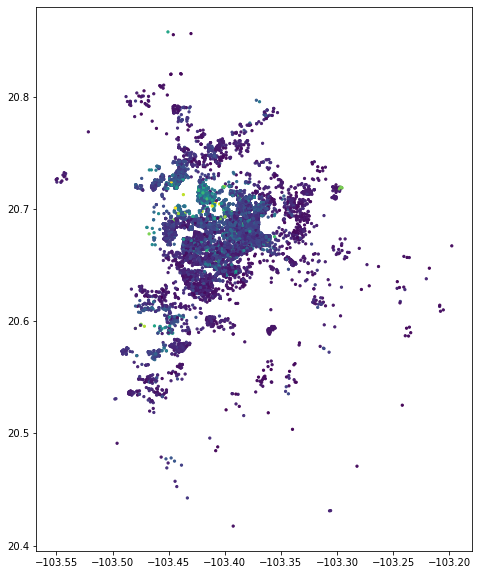

In [113]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot('Precio', markersize=5, ax=ax)

## Saving data

In [114]:
dir_grl = '/home/edgaregurrola/SIG/ObsCds/Proyectos/Costo_Vivienda/Medio_Urbano/Costo_Vivienda/'
gdf.to_file(dir_grl+f'{year}_{sheet}_PrecioVivienda_AMG_OC22_GCS_v1.geojson',
          driver='GeoJSON')